Original notebook that calculated layers of MoS2 using gradient descent

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
def lorentzian(x, x0, gamma, a):
    return (a / math.pi) * (gamma / ((x - x0) ** 2 + gamma ** 2))

def hypothesis(parameters, x):
    if isinstance(x, (list,np.ndarray)):
        y = np.empty((len(x)))
        for i in range(len(x)):
            output = 0
            for curve in parameters:
                output += lorentzian(x[i], curve[0], curve[1], curve[2])
            y[i] = output
        return y
    elif isinstance(x, float):
        output = 0
        for curve in parameters:
            output += lorentzian(x, curve[0], curve[1], curve[2])
        return output

In [4]:
def MSE_loss(x,y, parameters):
    assert len(x) == len(y)
    loss = np.array([0.5 * (hypothesis(parameters, x[i]) - y[i]) ** 2 for i in range(len(x))])
    return loss.sum()

In [5]:
def update(x,y,parameters, curve=-1,lr=0.0001):
    """Update parameters using gradient descent and MSE loss with one sample
    
    Parameters:
    x -- independent variable of data (usually first column of data, raman - (cm^-1), pl - (eV))
    y -- dependent variable of data (usually second column of data, intensity)
    parameters -- numpy array of parameters for curves used to fit data
    curve -- which curve to update; if left blank, update all
    lr -- sets how aggressively parameters are updated"""
    p_update = np.empty(parameters.shape)
    if curve == -1:
        for curve_ in range(len(parameters)):
            x0 = parameters[curve_][0]
            gamma = parameters[curve_][1]
            scaling = parameters[curve_][2]
            p_update[curve_][0] = lr * scaling * (2 * gamma) * (hypothesis(parameters, x) - y) * (x - x0) / (math.pi * ((x - x0) ** 2 + gamma ** 2) ** 2)
            p_update[curve_][1] = lr * scaling * ((1 / (math.pi * (gamma ** 2 + (x - x0) ** 2))) - ((2 * gamma ** 2) / (math.pi * (gamma ** 2 + (x - x0) ** 2) ** 2))) * (hypothesis(parameters, x) - y)
            p_update[curve_][2] = lr * (lorentzian(x, x0, gamma, scaling) / scaling) * (hypothesis(parameters, x) - y)
    else: 
        x0 = parameters[curve][0]
        gamma = parameters[curve][1]
        scaling = parameters[curve][2]
        p_update[curve][0] = lr * scaling * (2 * gamma) * (hypothesis(parameters, x) - y) * (x - x0) / (math.pi * ((x - x0) ** 2 + gamma ** 2) ** 2)
        p_update[curve][1] = lr * scaling * ((1 / (math.pi * (gamma ** 2 + (x - x0) ** 2))) - ((2 * gamma ** 2) / (math.pi * (gamma ** 2 + (x - x0) ** 2) ** 2))) * (hypothesis(parameters, x) - y)
        p_update[curve][2] = lr * (lorentzian(x, x0, gamma, scaling) / scaling) * (hypothesis(parameters, x) - y)
    parameters -= p_update
    return parameters

In [6]:
def batch_update(x, y, parameters, num_curves, lr=0.05):
    """Update parameters using batch gradient descent and MSE loss with all data
    
    Parameters:
    x -- list of independent variable of data (usually first column of data, raman - (cm^-1), pl - (eV))
    y -- list of dependent variable of data (usually second column of data, intensity)
    parameters -- numpy array of parameters for curves used to fit data
    lr -- sets how aggressively parameters are updated"""
    assert len(x) == len(y)
    for i in range(len(x)):
        # for j in range(len(parameters)):
        parameters = update(x[i], y[i], parameters, -1)
    return parameters

In [7]:
def graph_hypothesis(x, y, hypothesis=None, parameters=None, title=None):
    x_axis = np.linspace(x[0], x[-1])
    if hypothesis != None and parameters.all() != None:
        plt.plot(x, hypothesis(parameters,x), label="Lorentzian")
    plt.plot(x, y, label="Data")
    if title != None:
        plt.title(title)
    plt.show()

In [8]:
def get_peaks(data, n: int):
    assert isinstance(data, (list, np.ndarray))
    peaks = {}
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1]:
            peaks[i] = data[i]
    highest_peaks = dict(sorted(peaks.items(), key=lambda x: x[1], reverse=True))
    return list(highest_peaks.keys())

In [9]:
x_axis = []

In [10]:
def init_parameters(file, num_curves: int, spectroscopy="raman"):   
    parameters = np.zeros((num_curves, 3))
    # with open("Jacky/Raman/MoS2_1_loc1_r.txt", encoding='latin-1') as f:
    with open(file, encoding='latin-1') as f:
        data = f.readlines()
        data = data[32:] # skip metadata
        data = [data[i].split() for i in range(len(data))]
        # try:
        if len(data[0]) != 2:
            return None, None
        x = [float(data[i][0]) for i in range(len(data))]
        y = [float(data[i][1]) - ((float(data[-1][1]) + float(data[0][1])) / 3)  if float(data[i][1]) - float(data[-1][1]) > 0 else 0 for i in range(len(data))] # subtracts baseline
        #     x_axis = x
        # except:
        #     print(data)
        #     x = x_axis
        #     y = [float(data[i][0]) - ((float(data[-1][0]) + float(data[0][0])) / 3)  if float(data[i][0]) - float(data[-1][0]) > 0 else 0 for i in range(len(data))] # subtracts baseline
        a = sorted(y, reverse=True)
        data_peaks = get_peaks(y, num_curves)
        try:
            for i in range(len(parameters)):
                parameters[i][0] = x[data_peaks[i]]
                parameters[i][1] = 10
                parameters[i][2] = a[0] * 10
        except:
            print(x)
    return parameters, np.array([x,y])

In [11]:
def get_data(file:str, spectroscopy: str, graph=False):
    epochs = 2000
    num_curves = 0
    if spectroscopy == "raman":
        num_curves += 2
    elif spectroscopy == "pl":
        num_curves += 1
    parameters, raw_data = init_parameters(file, num_curves=2)
    try:
        if parameters.all() == None and raw_data.all() == None:
            return None
    except:
        return None
    print(parameters)
    if spectroscopy == "raman":
        data = np.split(raw_data, [len(raw_data // 2)], axis=1)
    else: 
        data = [raw_data]
    for _ in range(epochs):
        for i in range(len(data)):
            parameters = batch_update(data[i][0], data[i][1], parameters, num_curves=2)
    for i in range(num_curves):
        print(f'Loss for curve {i + 1} in {file} : {MSE_loss(data[i][0], data[i][1], parameters)}')
    print(parameters)
    if graph:
        graph_hypothesis(raw_data[0], raw_data[1], hypothesis, parameters, title = file)
    return parameters

In [12]:
def graph_txt(file):
    with open(file, encoding='latin-1') as f:
        data = f.readlines()
        data = data[32:] # skip metadata
        data = [data[i].split() for i in range(len(data))]
        x = [float(data[i][0]) for i in range(len(data))]
        y = [float(data[i][1]) for i in range(len(data))]
        plt.plot(x,y)
        plt.show()

In [15]:
def get_file_data(f):
    print(f)
    fit_parameters = get_data(f, spectroscopy="raman", graph=True)
    try:
        if fit_parameters.any() == None:
            return None, None, None
    except:
        return None, None, None 
    peaks = [fit_parameters[i][0] for i in range(len(fit_parameters))]
    flip = False
    try:
        peak1, peak2 = peaks
    except:
        print("Wrong number of peaks")
    if peak1 > peak2:
        temp = peak2
        peak2 = peak1
        peak1 = temp
    intensities = hypothesis(fit_parameters, peaks)
    return peak1, peak2, intensities

/Volumes/BEAR/Images_new/Raman/Sample 13/FeMoS2_1_loc2.txt
[[ 518.348    10.     3677.1242]
 [ 403.549    10.     3677.1242]]
Loss for curve 1 in /Volumes/BEAR/Images_new/Raman/Sample 13/FeMoS2_1_loc2.txt : 0.022849921673789932
Loss for curve 2 in /Volumes/BEAR/Images_new/Raman/Sample 13/FeMoS2_1_loc2.txt : 159279.14068729957
[[5.20513329e+02 3.65230085e+00 3.68449117e+03]
 [4.01950193e+02 9.59418867e+00 3.67713793e+03]]


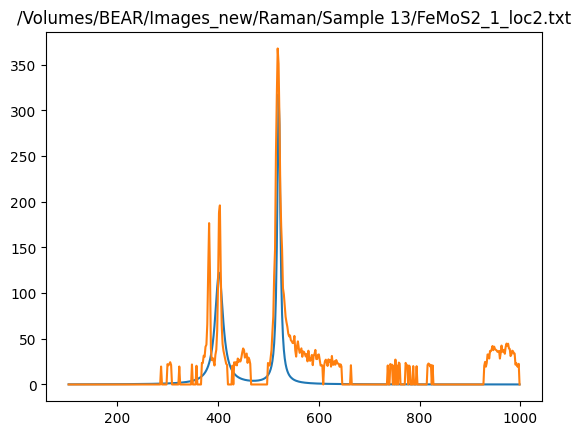

(np.float64(401.95019331987953),
 np.float64(520.5133290937581),
 array([321.90903697, 122.30216896]))

In [16]:
get_file_data('/Volumes/BEAR/Images_new/Raman/Sample 13/FeMoS2_1_loc2.txt')

In [48]:
def create_csv(folder, output_file):
    data = []
    # columns = ["Peak 1", "Peak 2", "Intensity 1", "Intensity 2"] if folder == "Raman" else ["Peak", "Intensity"]
    columns = ["File", "Peak 1", "Peak 2", "Intensity 1", "Intensity 2", "Peak Difference", "Intensity Difference"]
    if isinstance(folder, str):
        for filename in os.scandir("Jacky/" + folder):
            f = os.path.join("", filename)
            if f[-3:] != "txt":
                continue
            if os.path.isfile(f):
                peak1, peak2, intensities = get_file_data(f)
                try:
                    if peak1 == None or peak2 == None or intensities.any() == None:
                        continue
                except:
                    continue
                data.append([f, peak1, peak2])
                data[-1].extend(intensities)
                data[-1].extend([abs(peak2 - peak1), abs(intensities[0] - intensities[1])])
    elif isinstance(folder, list):
        for sample in folder:
            for filename in os.scandir("Jacky/" + sample):
                f = os.path.join("", filename)
                if f[-3:] != "txt":
                    continue
                if os.path.isfile(f):
                    peak1, peak2, intensities = get_file_data(f)
                    try:
                        if peak1 == None or peak2 == None or intensities.any() == None:
                            continue
                    except:
                        continue
                    data.append([f, peak1, peak2])
                    data[-1].extend(intensities)
                    data[-1].extend([abs(peak2 - peak1), abs(intensities[0] - intensities[1])])
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_file, header=True)
    return df, data

In [49]:
sample_folder_num = [1,2,3,4,11,12,13,14]
sample_folder_list = [f"Shivani/Shivani Sample {sample_folder_num[i]}" for i in range(len(sample_folder_num))]
sample_folder_list.append("Raman")

Jacky/Shivani/Shivani Sample 1/MoS2_3_loc4.txt
[[ 404.936    10.     2867.6611]
 [ 379.909    10.     2867.6611]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc4.txt : 0.7702463635743289
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc4.txt : 20571.611597513504
[[ 404.3654034     3.21527401 2866.54135344]
 [ 380.19333393    3.82597924 2864.5935358 ]]


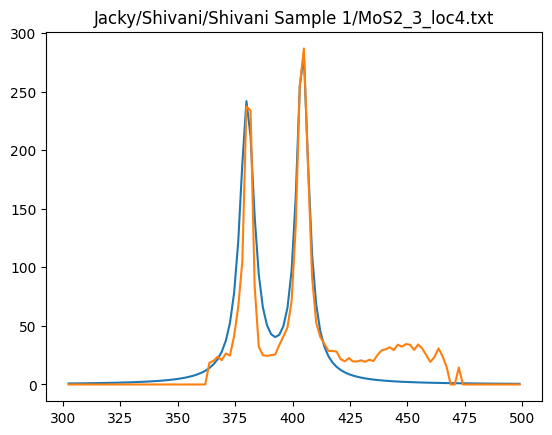

Jacky/Shivani/Shivani Sample 1/MoS2_3_loc5.txt
[[ 404.936        10.         2562.07373333]
 [ 381.701        10.         2562.07373333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc5.txt : 0.7135130435484884
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc5.txt : 16806.114332478654
[[ 405.0491245     3.2517396  2560.72208378]
 [ 380.68167225    4.32714327 2559.4387535 ]]


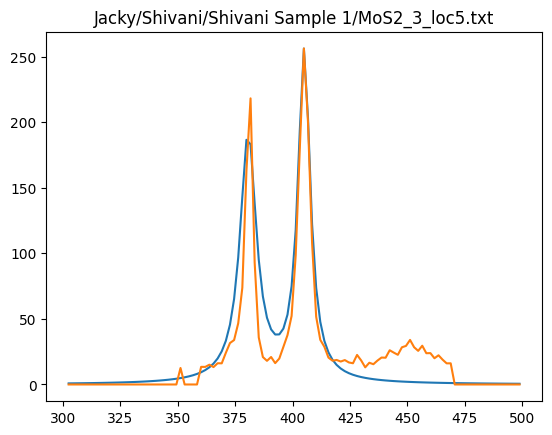

Jacky/Shivani/Shivani Sample 1/MoS2_2_loc2.txt
[[ 404.936        10.         3907.45663333]
 [ 381.701        10.         3907.45663333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_2_loc2.txt : 1.597699302605016
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_2_loc2.txt : 39566.24071332231
[[4.04936630e+02 3.44844666e+00 3.90515744e+03]
 [3.79980250e+02 4.01699054e+00 3.90309765e+03]]


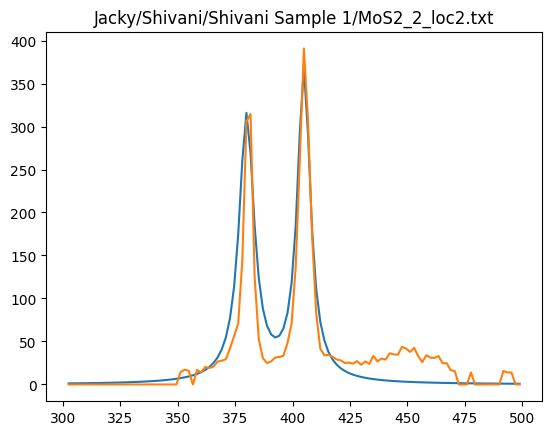

Jacky/Shivani/Shivani Sample 1/MoS2_3_loc2.txt
[[ 403.153        10.         1417.33736667]
 [ 381.701        10.         1417.33736667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc2.txt : 0.22013968035282422
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc2.txt : 6201.124632973851
[[ 402.82565191    3.28198    1416.70446346]
 [ 381.3512        4.32167097 1416.17834153]]


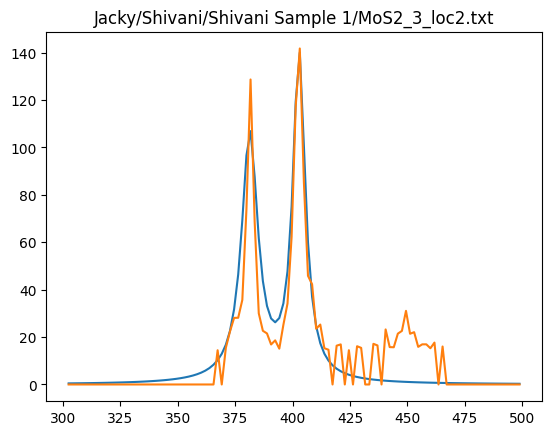

Jacky/Shivani/Shivani Sample 1/MoS2_3_loc3.txt
[[ 381.701        10.         1573.56566667]
 [ 401.367        10.         1573.56566667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc3.txt : 0.23333066501257965
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_3_loc3.txt : 8944.044709890642
[[ 381.405935      3.63866215 1571.99584692]
 [ 402.8895549     3.65128249 1573.11725694]]


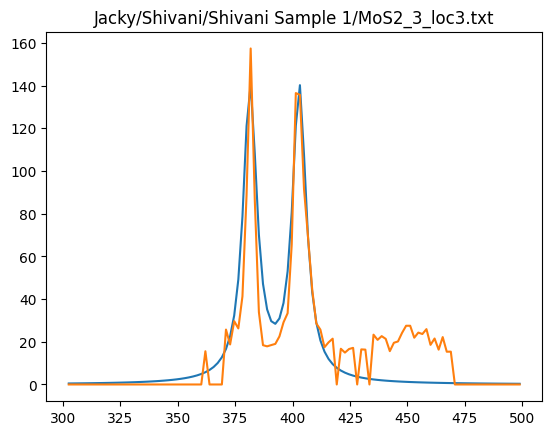

Jacky/Shivani/Shivani Sample 1/MoS2_2_loc3.txt
[302.471, 304.282, 306.093, 307.901, 309.712, 311.519, 313.329, 315.136, 316.943, 318.751, 320.557, 322.363, 324.168, 325.973, 327.777, 329.582, 331.385, 333.189, 334.992, 336.795, 338.595, 340.397, 342.197, 343.998, 345.797, 347.598, 349.396, 351.196, 352.994, 354.791, 356.588, 358.384, 360.181, 361.976, 363.772, 365.567, 367.362, 369.156, 370.948, 372.742, 374.535, 376.326, 378.119, 379.909, 381.701, 383.491, 385.28, 387.069, 388.859, 390.647, 392.435, 394.223, 396.01, 397.795, 399.581, 401.367, 403.153, 404.936, 406.721, 408.506, 410.288, 412.072, 413.854, 415.635, 417.418, 419.198, 420.979, 422.759, 424.538, 426.317, 428.096, 429.875, 431.653, 433.431, 435.206, 436.983, 438.758, 440.534, 442.308, 444.084, 445.857, 447.632, 449.405, 451.177, 452.949, 454.721, 456.492, 458.263, 460.034, 461.804, 463.574, 465.343, 467.111, 468.879, 470.646, 472.414, 474.18, 475.948, 477.713, 479.477, 481.244, 483.008, 484.772, 486.535, 488.298, 490.061, 4

/var/folders/08/551bq3_17bqcdv104sd7yclm0000gn/T/ipykernel_2645/2683149957.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p_update[curve_][2] = lr * (lorentzian(x, x0, gamma, scaling) / scaling) * (hypothesis(parameters, x) - y)


Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_2_loc3.txt : nan
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_2_loc3.txt : nan
[[nan nan nan]
 [nan nan nan]]


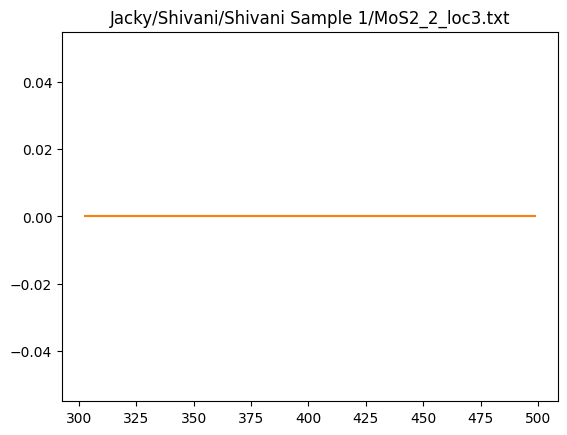

Jacky/Shivani/Shivani Sample 1/MoS2_2_loc1.txt
[[ 404.936    10.     4183.4224]
 [ 381.701    10.     4183.4224]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_2_loc1.txt : 1.8252845821080077
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_2_loc1.txt : 44401.535793894596
[[4.05173918e+02 3.37949122e+00 4.18141583e+03]
 [3.79939105e+02 4.05055728e+00 4.17910238e+03]]


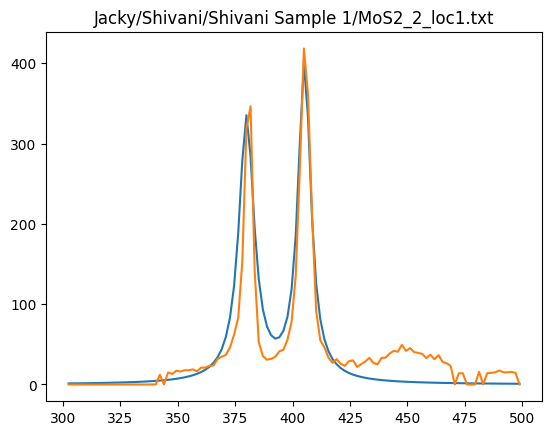

Jacky/Shivani/Shivani Sample 1/MoS2_4_loc2.txt
[[403.153       10.         668.28093333]
 [381.701       10.         668.28093333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc2.txt : 0.04919128713057952
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc2.txt : 1571.1260084607584
[[402.77780472   3.09607827 668.07441519]
 [381.05816373   4.41733384 667.74368157]]


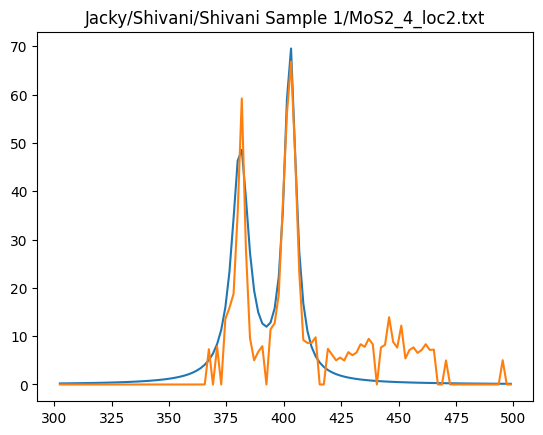

Jacky/Shivani/Shivani Sample 1/MoS2_4_loc3.txt
[[ 403.153        10.         2578.86683333]
 [ 379.909        10.         2578.86683333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc3.txt : 0.6252581422658072
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc3.txt : 14431.8093011176
[[ 404.02691908    3.03578518 2577.67421576]
 [ 379.89340325    3.8982204  2576.34651086]]


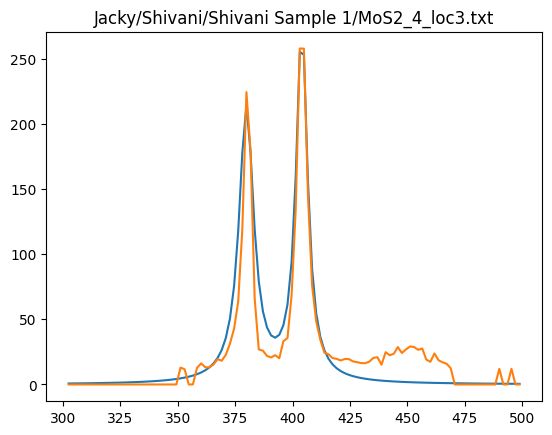

Jacky/Shivani/Shivani Sample 1/MoS2_4_loc1.txt
[[383.491       10.         321.28623333]
 [404.936       10.         321.28623333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc1.txt : 0.006380765466866754
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc1.txt : 422.6417736300728
[[382.6835154    3.14063894 321.03520266]
 [403.68773713   2.84640326 321.08738363]]


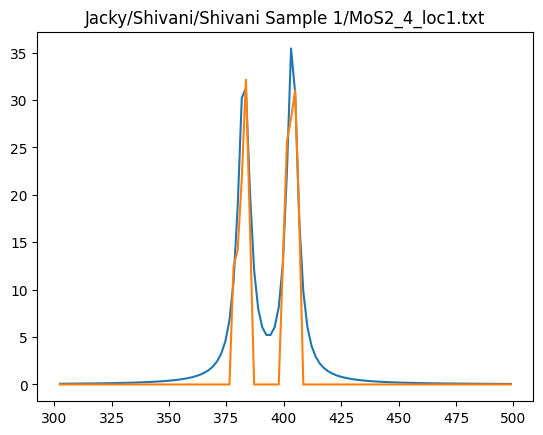

Jacky/Shivani/Shivani Sample 1/MoS2_4_loc4.txt
[[ 404.936        10.         3151.53066667]
 [ 379.909        10.         3151.53066667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc4.txt : 1.0751499247462173
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc4.txt : 25273.35924341695
[[ 404.58177729    3.31513712 3148.92388522]
 [ 379.07423536    4.08476451 3147.80269047]]


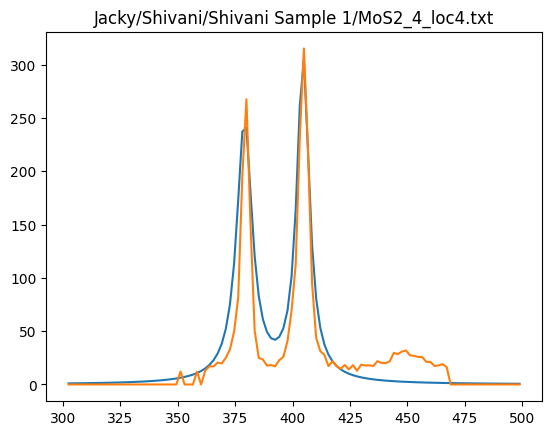

Jacky/Shivani/Shivani Sample 1/MoS2_4_loc5.txt
[[381.701       10.         892.13103333]
 [403.153       10.         892.13103333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc5.txt : 0.06385987928124107
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_4_loc5.txt : 2183.7929395758774
[[381.48081307   3.50827466 891.43244491]
 [403.1336632    3.1472399  891.96249259]]


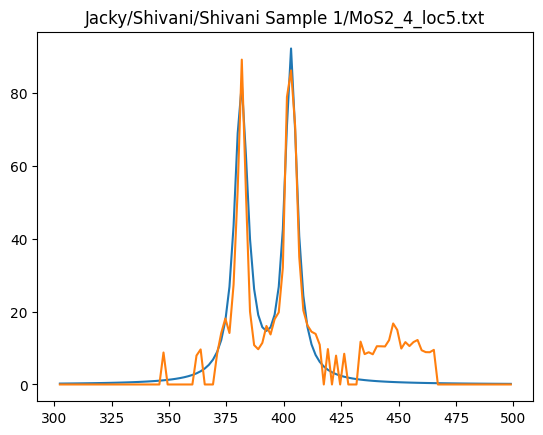

Jacky/Shivani/Shivani Sample 1/MoS2_1_loc1.txt
[[ 406.721        10.         5086.52863333]
 [ 379.909        10.         5086.52863333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc1.txt : 4.282681990082761
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc1.txt : 382779.75466932
[[1.11453347e+03 3.33158853e+02 5.08651721e+03]
 [3.79108091e+02 4.86508649e+00 5.08406861e+03]]


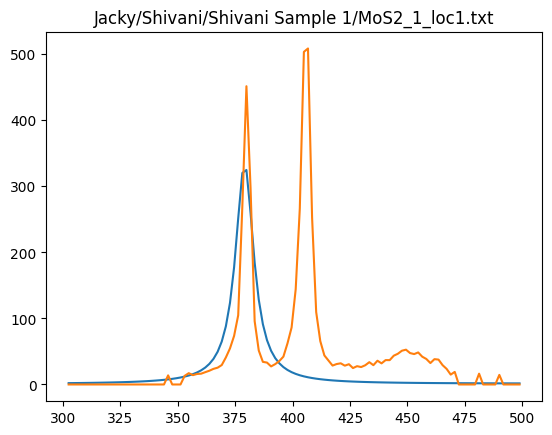

Jacky/Shivani/Shivani Sample 1/MoS2_1_loc2.txt
[[ 404.936    10.     2136.8625]
 [ 379.909    10.     2136.8625]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc2.txt : 0.5414572359412295
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc2.txt : 12436.081773801514
[[ 404.78369785    3.30394878 2135.21871273]
 [ 380.3249599     4.52289895 2134.72127471]]


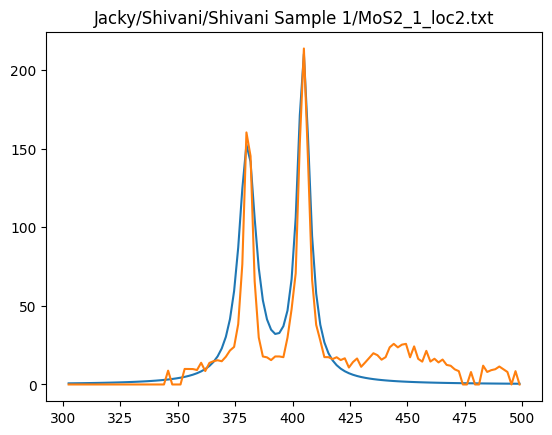

Jacky/Shivani/Shivani Sample 1/MoS2_1_loc3.txt
[[ 403.153        10.         1483.69033333]
 [ 381.701        10.         1483.69033333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc3.txt : 0.24955646545659446
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc3.txt : 7239.740382649323
[[ 403.09312715    3.3745234  1482.80447662]
 [ 381.33296821    4.38313834 1482.4529929 ]]


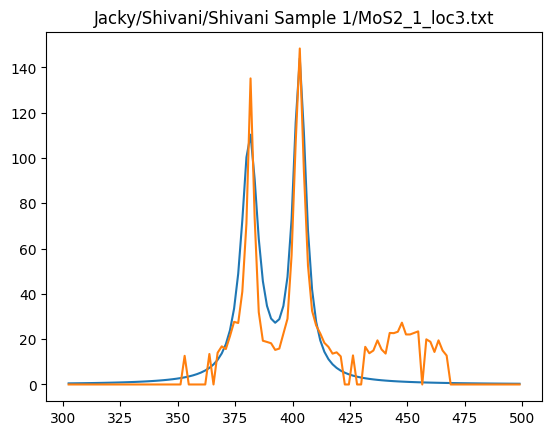

Jacky/Shivani/Shivani Sample 1/MoS2_1_loc6.txt
[[ 406.721    10.     3514.3775]
 [ 379.909    10.     3514.3775]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc6.txt : 1.1941971113322758
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc6.txt : 33554.644293876525
[[4.05543701e+02 3.14341514e+00 3.51202314e+03]
 [3.79492371e+02 3.92941235e+00 3.51021228e+03]]


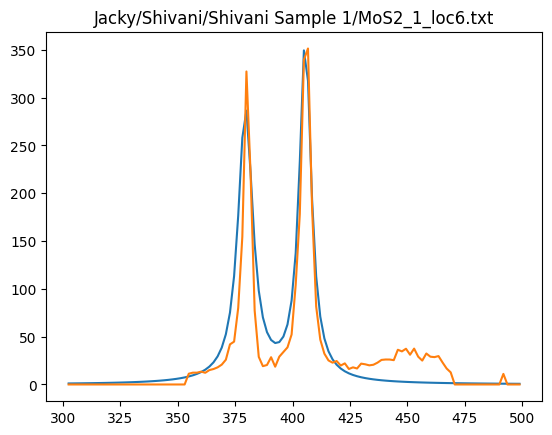

Jacky/Shivani/Shivani Sample 1/MoS2_1_loc4.txt
[[ 404.936        10.         3823.21973333]
 [ 381.701        10.         3823.21973333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc4.txt : 1.8789316079936533
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc4.txt : 42563.22774297664
[[4.04681829e+02 3.55912004e+00 3.82028589e+03]
 [3.80054885e+02 4.60524664e+00 3.81896346e+03]]


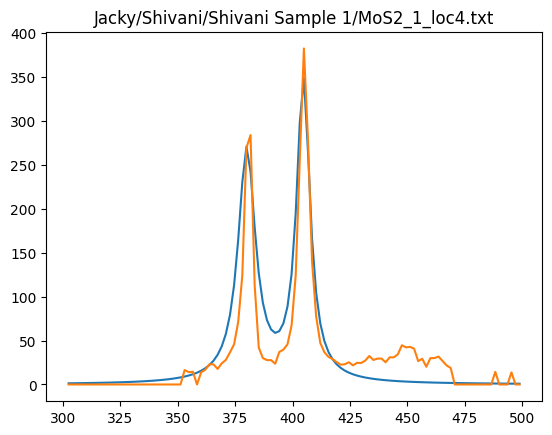

Jacky/Shivani/Shivani Sample 1/MoS2_1_loc5.txt
[[ 404.936        10.         2088.39363333]
 [ 381.701        10.         2088.39363333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc5.txt : 0.35657773719703123
Loss for curve 2 in Jacky/Shivani/Shivani Sample 1/MoS2_1_loc5.txt : 11502.841490403907
[[ 404.34219016    3.12658063 2088.05970852]
 [ 381.00988681    3.57532801 2086.39639632]]


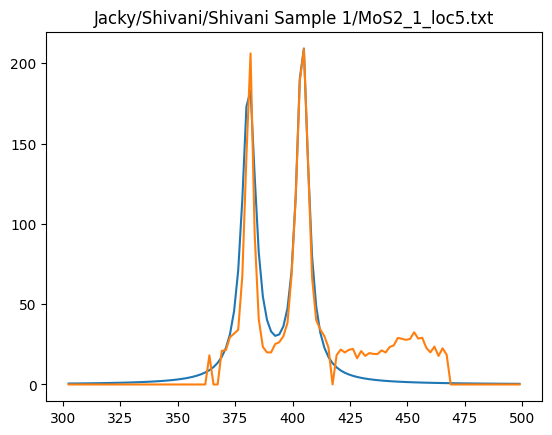

Jacky/Shivani/Shivani Sample 2/MoS2_1_loc1.txt
[[ 404.936        10.         4489.13736667]
 [ 379.909        10.         4489.13736667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 2/MoS2_1_loc1.txt : 2.442896178839835
Loss for curve 2 in Jacky/Shivani/Shivani Sample 2/MoS2_1_loc1.txt : 50313.84770829455
[[4.04643566e+02 3.18645680e+00 4.48599283e+03]
 [3.78241327e+02 4.40798421e+00 4.48433903e+03]]


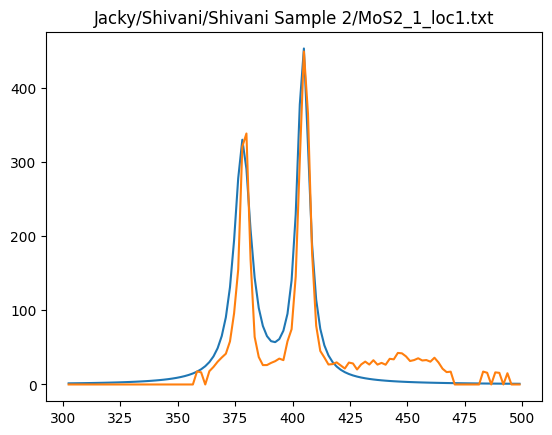

Jacky/Shivani/Shivani Sample 2/MoS2_1_loc2.txt
[[ 403.153        10.         1388.14816667]
 [ 381.701        10.         1388.14816667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 2/MoS2_1_loc2.txt : 0.217316759519454
Loss for curve 2 in Jacky/Shivani/Shivani Sample 2/MoS2_1_loc2.txt : 5017.518428466111
[[ 402.72266475    3.15477501 1387.4148737 ]
 [ 380.75459814    4.42050637 1386.89221439]]


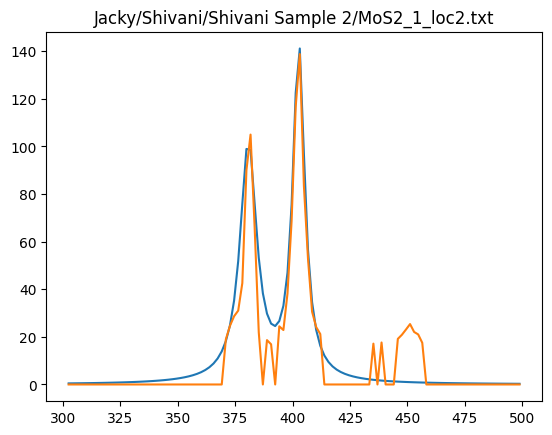

Jacky/Shivani/Shivani Sample 2/MoS2_1_loc3.txt
[[406.721       10.         664.82747667]
 [381.701       10.         664.82747667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 2/MoS2_1_loc3.txt : 0.023458008026947027
Loss for curve 2 in Jacky/Shivani/Shivani Sample 2/MoS2_1_loc3.txt : 1666.5043271295913
[[407.44254839   2.87828121 664.13722818]
 [380.59623485   4.40719419 664.14817362]]


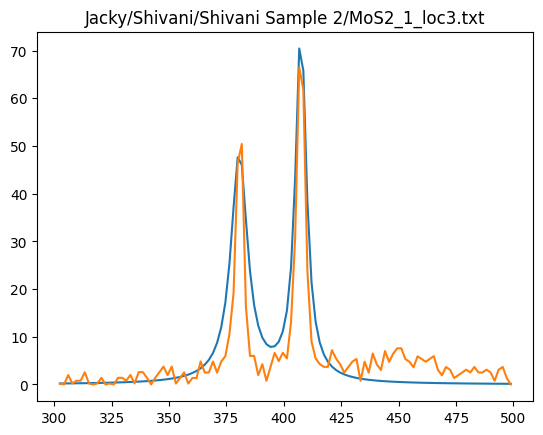

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc8.txt
[[ 403.153   10.    1920.475]
 [ 378.119   10.    1920.475]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc8.txt : 0.3381082258024417
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc8.txt : 6646.063975880746
[[ 402.64182813    3.27795751 1920.57532113]
 [ 377.96959993    3.44943248 1919.44289309]]


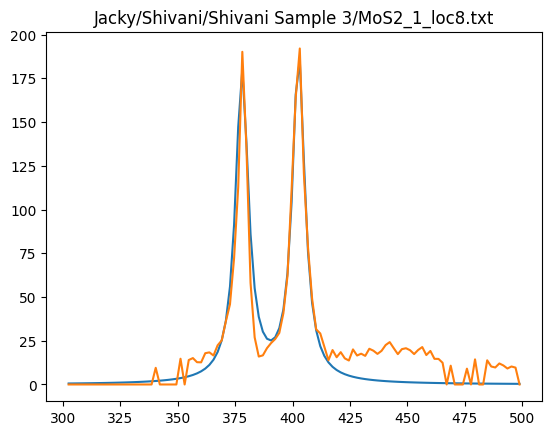

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc1.txt
[[ 379.909    10.     1606.2894]
 [ 401.367    10.     1606.2894]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc1.txt : 0.2235385900228361
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc1.txt : 5538.472035845946
[[ 379.82744951    3.41722099 1605.19696305]
 [ 401.05965687    3.2578244  1606.33518065]]


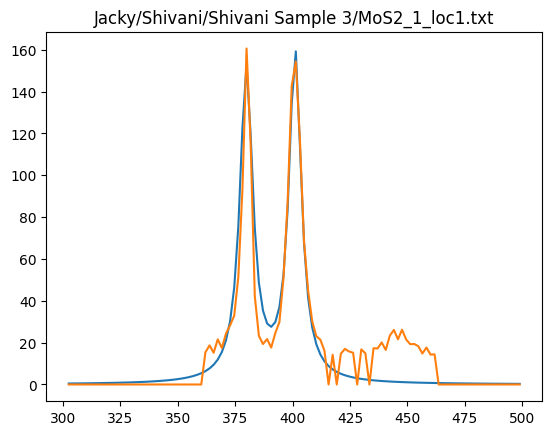

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc2.txt
[[ 378.119        10.         1718.48183333]
 [ 401.367        10.         1718.48183333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc2.txt : 0.233503565295233
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc2.txt : 4644.065801875029
[[ 378.63531465    3.06290452 1717.51120025]
 [ 401.9545317     3.33893997 1718.8684078 ]]


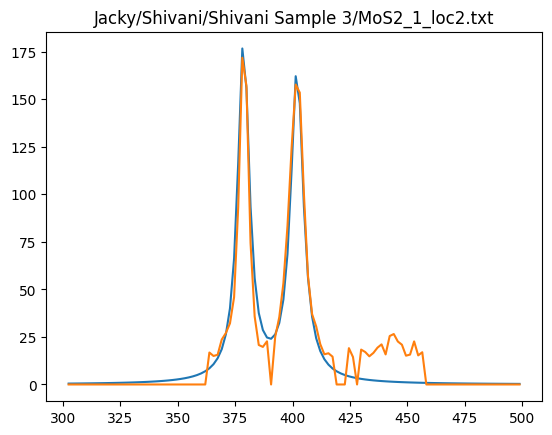

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc3.txt
[[ 401.367        10.         2386.18486667]
 [ 378.119        10.         2386.18486667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc3.txt : 0.4778954556348853
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc3.txt : 9144.26707065862
[[ 402.22041318    3.02504838 2386.66492745]
 [ 378.26852978    3.37494632 2384.9465535 ]]


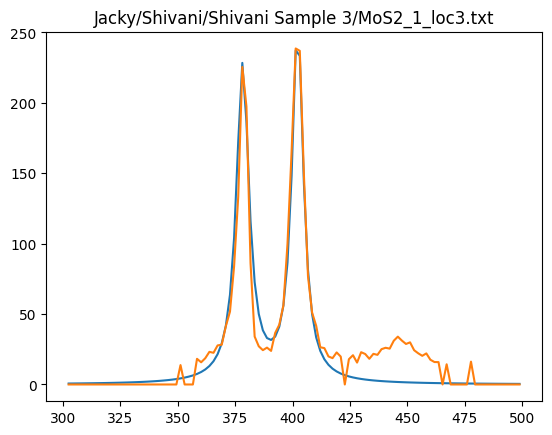

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc7.txt
[[ 378.119    10.     3235.5424]
 [ 403.153    10.     3235.5424]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc7.txt : 0.9574828250110825
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc7.txt : 17717.10549825656
[[ 377.52861628    3.37991609 3232.75505369]
 [ 402.73037894    3.32772678 3234.38313524]]


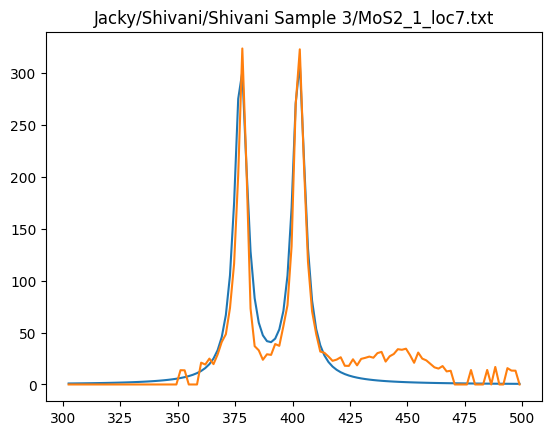

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc6.txt
[[ 404.936        10.         1842.82939333]
 [ 378.119        10.         1842.82939333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc6.txt : 0.7852467222259506
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc6.txt : 13720.290094751052
[[ 404.85561427    3.43552609 1840.23472222]
 [ 378.19032635    6.64702449 1840.71645553]]


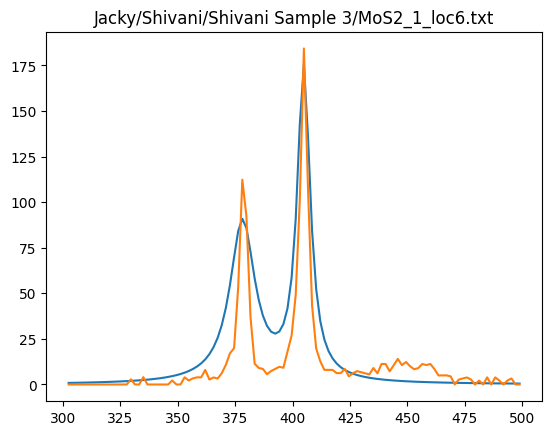

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc4.txt
[[ 379.909        10.         1485.34626667]
 [ 399.581        10.         1485.34626667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc4.txt : 0.21603078991195124
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc4.txt : 5375.932534460152
[[ 379.81942993    3.48843882 1484.0341768 ]
 [ 400.6315939     3.66915994 1484.97369281]]


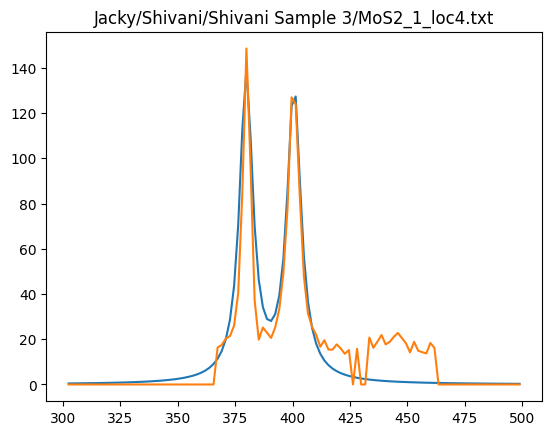

Jacky/Shivani/Shivani Sample 3/MoS2_1_loc5.txt
[[ 378.119        10.         3121.92916667]
 [ 403.153        10.         3121.92916667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc5.txt : 0.8848020611758474
Loss for curve 2 in Jacky/Shivani/Shivani Sample 3/MoS2_1_loc5.txt : 14967.997667432477
[[ 377.81708982    3.31270703 3119.5853709 ]
 [ 403.11816886    3.48394352 3122.19225228]]


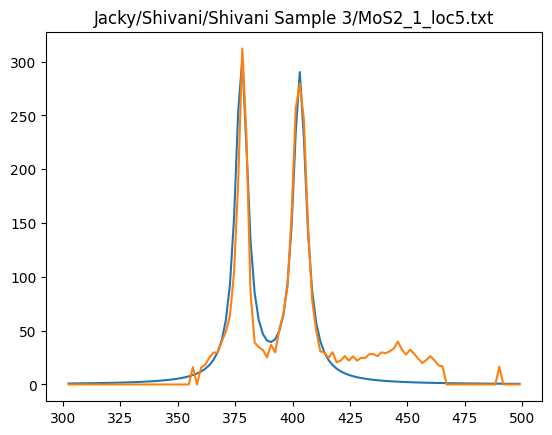

Jacky/Shivani/Shivani Sample 4/MoS2_1_loc1.txt
[[ 379.909        10.         1377.53603333]
 [ 401.367        10.         1377.53603333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 4/MoS2_1_loc1.txt : 0.20345710652356447
Loss for curve 2 in Jacky/Shivani/Shivani Sample 4/MoS2_1_loc1.txt : 5270.2087757263
[[ 379.23039892    3.53134023 1376.33988979]
 [ 403.26326103    4.16007584 1377.46177854]]


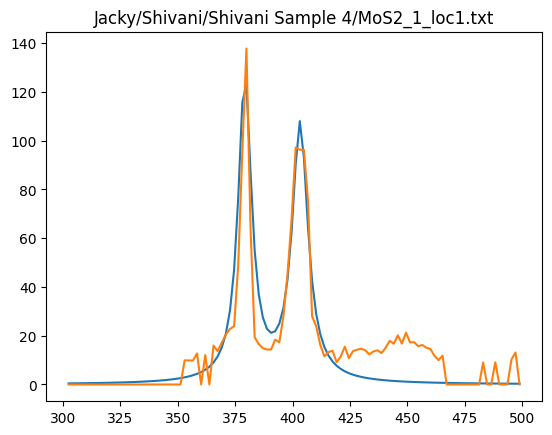

Jacky/Shivani/Shivani Sample 4/MoS2_1_loc2.txt
[[401.367       10.         905.19666667]
 [379.909       10.         905.19666667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 4/MoS2_1_loc2.txt : 0.10698252302366623
Loss for curve 2 in Jacky/Shivani/Shivani Sample 4/MoS2_1_loc2.txt : 2497.355247953909
[[401.63741288   3.162907   904.87681912]
 [379.83994391   4.74178594 904.5586846 ]]


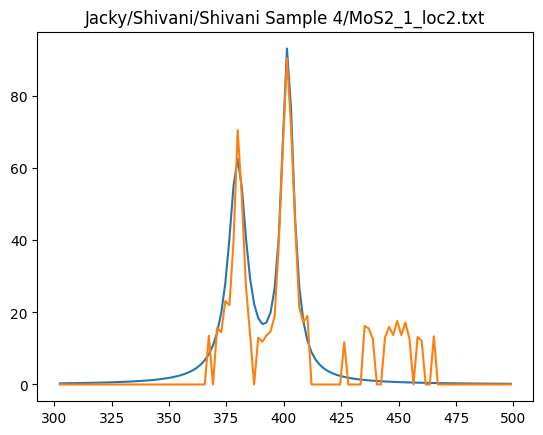

Jacky/Shivani/Shivani Sample 4/MoS2_1_loc3.txt
[[ 379.909        10.         1215.92773333]
 [ 401.367        10.         1215.92773333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 4/MoS2_1_loc3.txt : 0.13196543573663233
Loss for curve 2 in Jacky/Shivani/Shivani Sample 4/MoS2_1_loc3.txt : 4481.911649076191
[[ 379.49536202    3.53767744 1214.41841727]
 [ 400.99414046    3.14504844 1215.25906409]]


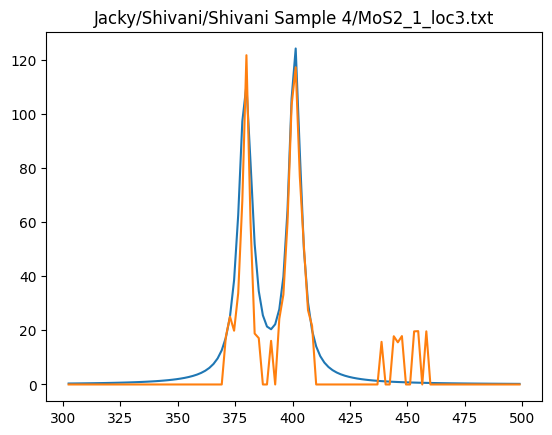

Jacky/Shivani/Shivani Sample 11/FeMoS2_2_loc2.txt
[[516.596  10.    780.82 ]
 [401.768  10.    780.82 ]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 11/FeMoS2_2_loc2.txt : 0.0007563991087664668
Loss for curve 2 in Jacky/Shivani/Shivani Sample 11/FeMoS2_2_loc2.txt : 4746.706983971082
[[517.07857311   3.46784349 782.03895166]
 [401.61886374   8.00208735 780.38087392]]


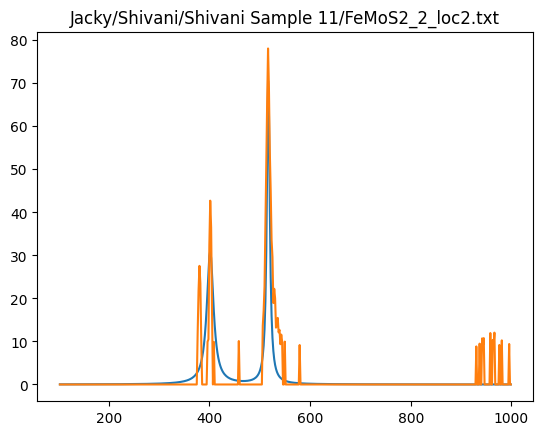

Jacky/Shivani/Shivani Sample 11/FeMoS2_2_loc1.txt
[[ 516.596        10.         1045.02443333]
 [ 401.768        10.         1045.02443333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 11/FeMoS2_2_loc1.txt : 0.0031313415240469293
Loss for curve 2 in Jacky/Shivani/Shivani Sample 11/FeMoS2_2_loc1.txt : 13280.498006277056
[[ 517.23189361    3.42611937 1046.56620781]
 [ 399.94077585   12.98835282 1044.98868367]]


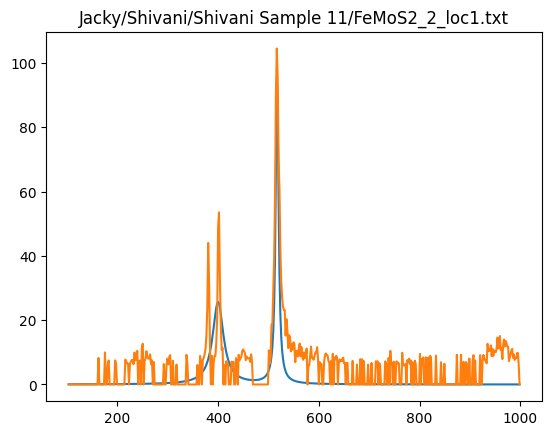

Jacky/Shivani/Shivani Sample 11/FeMoS2_1_loc1.txt
[[ 403.549        10.         1188.77016667]
 [ 516.596        10.         1188.77016667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 11/FeMoS2_1_loc1.txt : 0.0005730829183134707
Loss for curve 2 in Jacky/Shivani/Shivani Sample 11/FeMoS2_1_loc1.txt : 27414.63037918896
[[ 403.28157935    3.48658873 1188.80554776]
 [ 517.40120093    4.14907878 1190.03172517]]


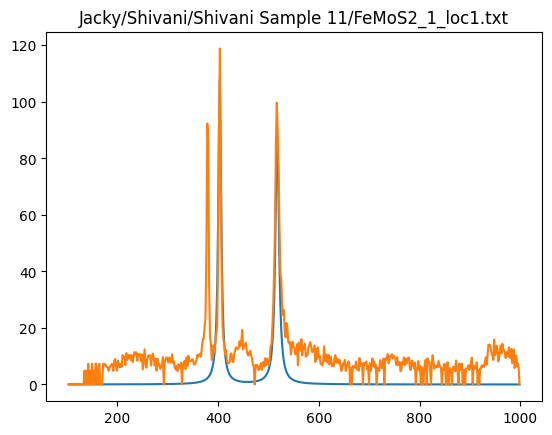

Jacky/Shivani/Shivani Sample 11/FeMoS2_1_loc2.txt
[[518.348   10.     750.7632]
 [403.549   10.     750.7632]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 11/FeMoS2_1_loc2.txt : 0.00032052194967193207
Loss for curve 2 in Jacky/Shivani/Shivani Sample 11/FeMoS2_1_loc2.txt : 6421.6906236642835
[[517.70374961   3.35763553 751.94073525]
 [402.32441307   4.9172165  750.50801585]]


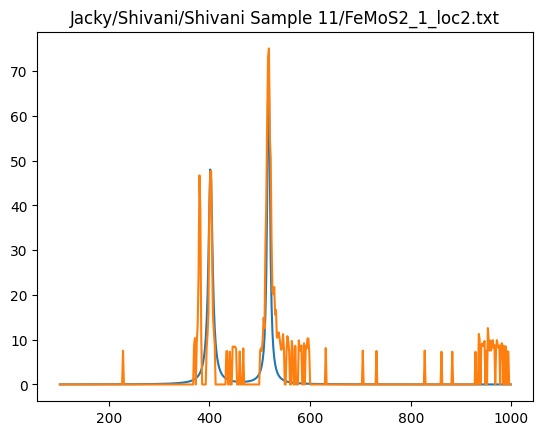

Jacky/Shivani/Shivani Sample 12/FeMoS2_1_loc1.txt
[[516.596       10.         878.13503333]
 [401.768       10.         878.13503333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 12/FeMoS2_1_loc1.txt : 0.0006522589402599106
Loss for curve 2 in Jacky/Shivani/Shivani Sample 12/FeMoS2_1_loc1.txt : 11784.073452457385
[[517.18143976   3.55931171 879.67839044]
 [401.0612117    6.21823536 877.97248261]]


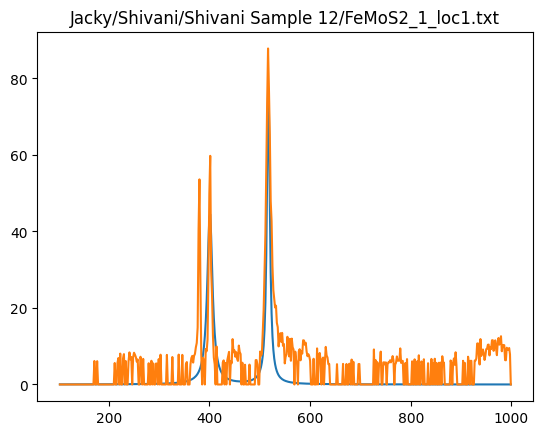

Jacky/Shivani/Shivani Sample 12/FeMoS2_1_loc2.txt
[[518.348   10.     811.9981]
 [401.768   10.     811.9981]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 12/FeMoS2_1_loc2.txt : 0.00036548764505417225
Loss for curve 2 in Jacky/Shivani/Shivani Sample 12/FeMoS2_1_loc2.txt : 10917.942252261295
[[517.5899666    3.40258642 813.79801345]
 [401.24203744   4.77370626 811.4677228 ]]


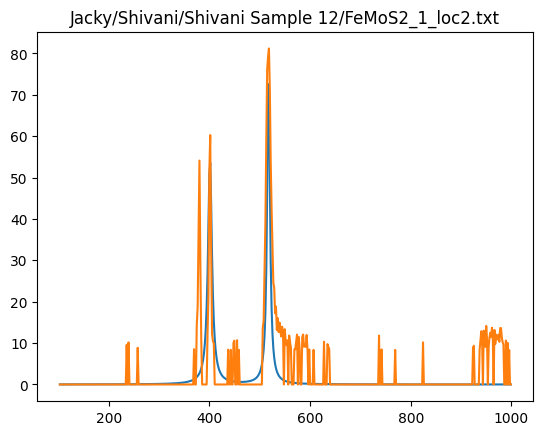

Jacky/Shivani/Shivani Sample 13/FeMoS2_1_loc1.txt
[[ 518.348    10.     2968.4094]
 [ 401.768    10.     2968.4094]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 13/FeMoS2_1_loc1.txt : 0.03185894995924089
Loss for curve 2 in Jacky/Shivani/Shivani Sample 13/FeMoS2_1_loc1.txt : 110475.00301688205
[[ 519.79993494    3.57934163 2974.49912078]
 [ 400.23838934   14.77804897 2969.20570982]]


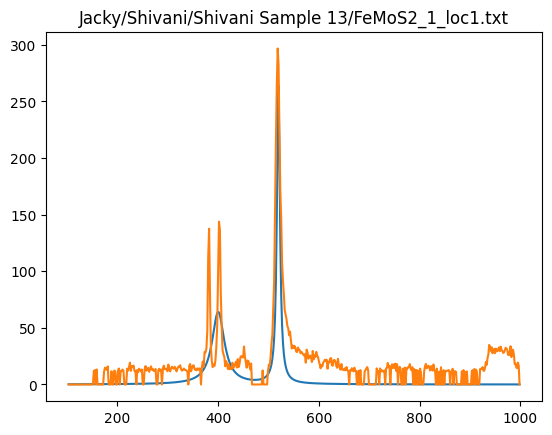

Jacky/Shivani/Shivani Sample 13/FeMoS2_1_loc2.txt
[[ 518.348    10.     3677.1242]
 [ 403.549    10.     3677.1242]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 13/FeMoS2_1_loc2.txt : 0.022849921673789932
Loss for curve 2 in Jacky/Shivani/Shivani Sample 13/FeMoS2_1_loc2.txt : 159279.14068729957
[[5.20513329e+02 3.65230085e+00 3.68449117e+03]
 [4.01950193e+02 9.59418867e+00 3.67713793e+03]]


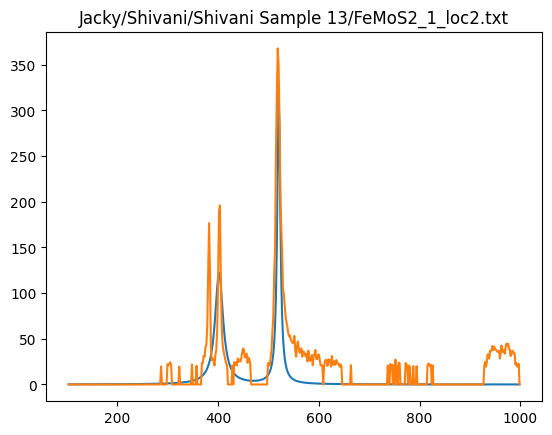

Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc1.txt
[[ 405.33         10.         6683.31366667]
 [ 380.35         10.         6683.31366667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc1.txt : 0.03922126614480466
Loss for curve 2 in Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc1.txt : 463066.6749069236
[[4.04201523e+02 3.62068355e+00 6.68234755e+03]
 [3.78199607e+02 3.97803055e+00 6.67802812e+03]]


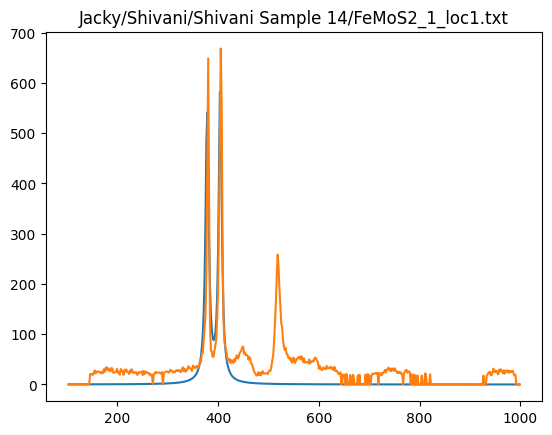

Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc2.txt
[[ 520.098        10.         3593.09373333]
 [ 405.33         10.         3593.09373333]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc2.txt : 0.005920494036054909
Loss for curve 2 in Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc2.txt : 288137.6244678548
[[ 520.74779209    3.74880952 3601.58808442]
 [ 404.60618882    4.12035644 3593.75847381]]


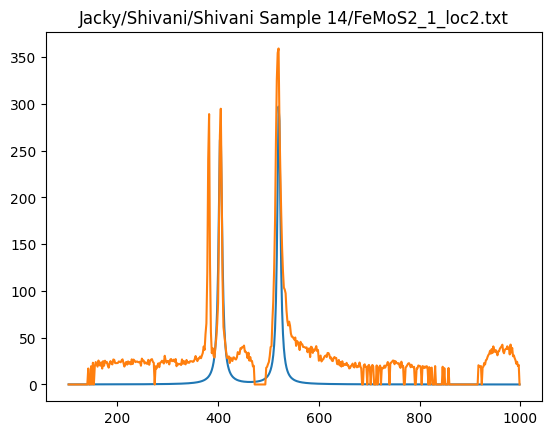

Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc3.txt
[[ 405.33         10.         4938.86206667]
 [ 380.35         10.         4938.86206667]]
Loss for curve 1 in Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc3.txt : 0.0331156430498835
Loss for curve 2 in Jacky/Shivani/Shivani Sample 14/FeMoS2_1_loc3.txt : 130189.82166715516
[[4.05139150e+02 4.56546427e+00 4.93607085e+03]
 [3.78409919e+02 4.92906988e+00 4.93307367e+03]]


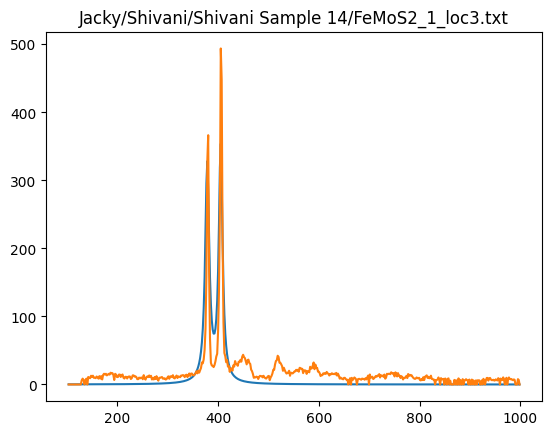

Jacky/Raman/MoS2_5_loc3_r.txt
Jacky/Raman/MoS2_2_loc4_r.txt
[[ 411.482    10.     1349.7369]
 [ 386.955    10.     1349.7369]]
Loss for curve 1 in Jacky/Raman/MoS2_2_loc4_r.txt : 2.33211092680435
Loss for curve 2 in Jacky/Raman/MoS2_2_loc4_r.txt : 1384.3819184003014
[[ 411.38012685    3.13464057 1349.70183949]
 [ 385.42465529    3.06350425 1349.08332355]]


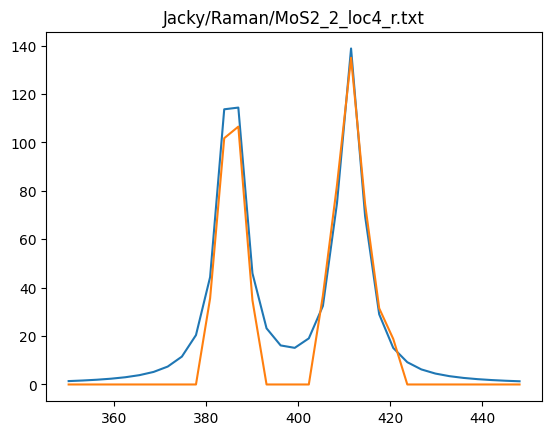

Jacky/Raman/MoS2_2_loc6_r.txt
[[ 411.482        10.         1707.79823333]
 [ 383.886        10.         1707.79823333]]
Loss for curve 1 in Jacky/Raman/MoS2_2_loc6_r.txt : 5.483146248571523
Loss for curve 2 in Jacky/Raman/MoS2_2_loc6_r.txt : 2134.8325799181566
[[ 410.71531686    3.00122101 1708.13048213]
 [ 384.9820352     3.86126693 1707.33993499]]


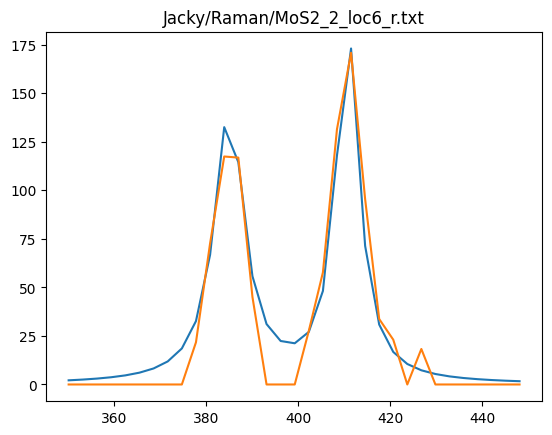

Jacky/Raman/MoS2_5_loc1_r.txt
Jacky/Raman/MoS2_2_loc2.txt
[[ 408.419        10.         1091.34563333]
 [ 386.955        10.         1091.34563333]]
Loss for curve 1 in Jacky/Raman/MoS2_2_loc2.txt : 1.2999394761173186
Loss for curve 2 in Jacky/Raman/MoS2_2_loc2.txt : 1172.4083392670948
[[ 409.81495833    2.70723097 1091.84481113]
 [ 385.45737539    2.84088597 1091.4214301 ]]


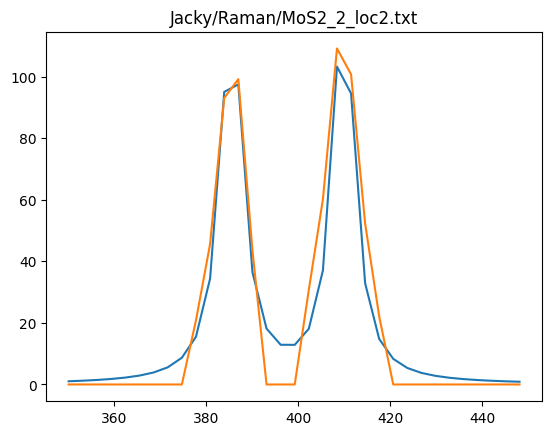

Jacky/Raman/MoS2_5_loc2_r.txt
Jacky/Raman/MoS2_2_loc5_r.txt
[[411.482    10.      839.34759]
 [383.886    10.      839.34759]]
Loss for curve 1 in Jacky/Raman/MoS2_2_loc5_r.txt : 1.1072482188675734
Loss for curve 2 in Jacky/Raman/MoS2_2_loc5_r.txt : 713.9350485872491
[[410.10258453   2.70996433 839.75384078]
 [384.10992971   3.32880418 839.2589069 ]]


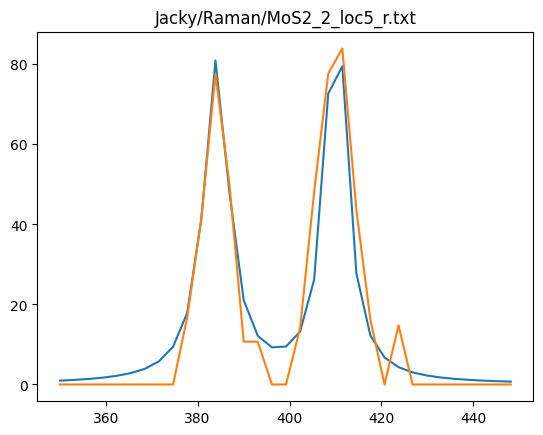

Jacky/Raman/MoS2_2_loc1_r.txt
[[386.955       10.         533.84206667]
 [408.419       10.         533.84206667]]
Loss for curve 1 in Jacky/Raman/MoS2_2_loc1_r.txt : 0.36761075022963163
Loss for curve 2 in Jacky/Raman/MoS2_2_loc1_r.txt : 793.3859574235157
[[387.53200245   3.24639352 534.13911153]
 [408.66148355   3.42970151 534.39659801]]


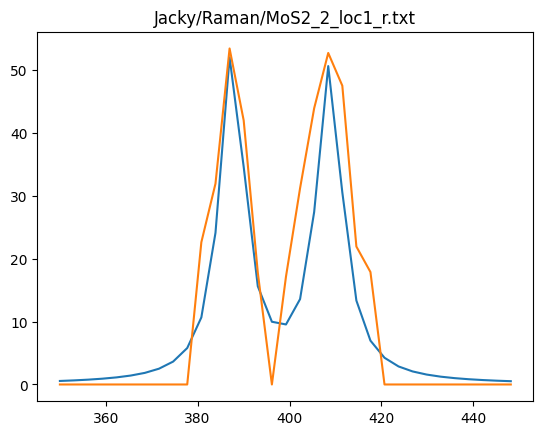

Jacky/Raman/MoS2_5_loc4_r.txt
Jacky/Raman/MoS2_2_loc3_r.txt
[[ 411.482        10.         1031.96306667]
 [ 386.955        10.         1031.96306667]]
Loss for curve 1 in Jacky/Raman/MoS2_2_loc3_r.txt : 1.3093797505438385
Loss for curve 2 in Jacky/Raman/MoS2_2_loc3_r.txt : 1384.9008948827764
[[ 410.31707957    2.90984131 1032.58371079]
 [ 385.86276913    3.096766   1032.05540274]]


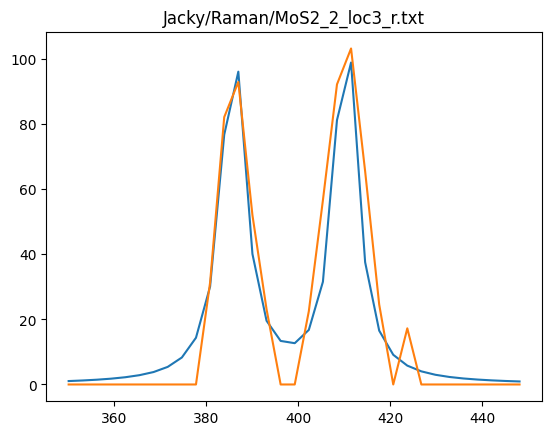

Jacky/Raman/MoS2_3_loc2_r.txt
[[ 408.419        10.         1131.52233333]
 [ 386.955        10.         1131.52233333]]
Loss for curve 1 in Jacky/Raman/MoS2_3_loc2_r.txt : 2.546365516012445
Loss for curve 2 in Jacky/Raman/MoS2_3_loc2_r.txt : 1066.1311340552606
[[ 409.07865032    3.18772958 1132.00461859]
 [ 385.59292171    4.0266382  1131.46191057]]


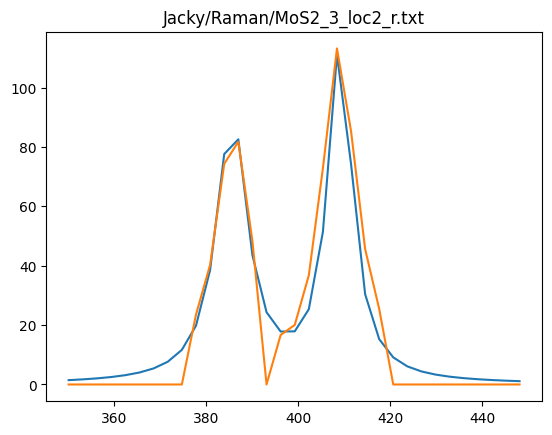

Jacky/Raman/MoS2_1_loc1_r.txt
[[ 407.012     10.      1017.15653]
 [ 385.54      10.      1017.15653]]
Loss for curve 1 in Jacky/Raman/MoS2_1_loc1_r.txt : 0.1044966844163755
Loss for curve 2 in Jacky/Raman/MoS2_1_loc1_r.txt : 8489.441238705496
[[ 407.79114591    3.69982541 1018.21652562]
 [ 386.38261972    4.4802494  1018.00153889]]


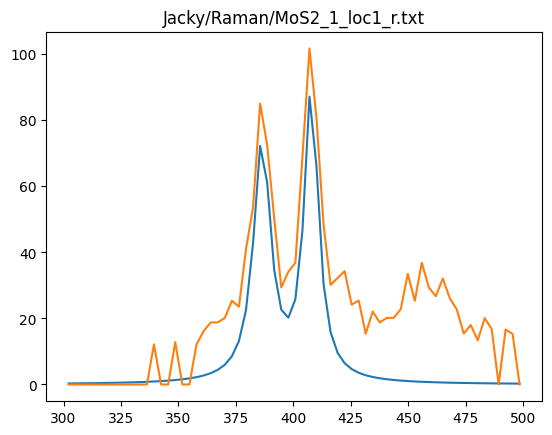

Jacky/Raman/FeMoS2_1_loc5_r.txt
Jacky/Raman/MoS2_1_loc3_r.txt
[[411.482    10.      176.78759]
 [405.357    10.      176.78759]]
Loss for curve 1 in Jacky/Raman/MoS2_1_loc3_r.txt : 26.094175035133116
Loss for curve 2 in Jacky/Raman/MoS2_1_loc3_r.txt : 377.1488893377714
[[410.90716609   9.81474476 176.96551112]
 [404.74586239   9.98827878 176.98399933]]


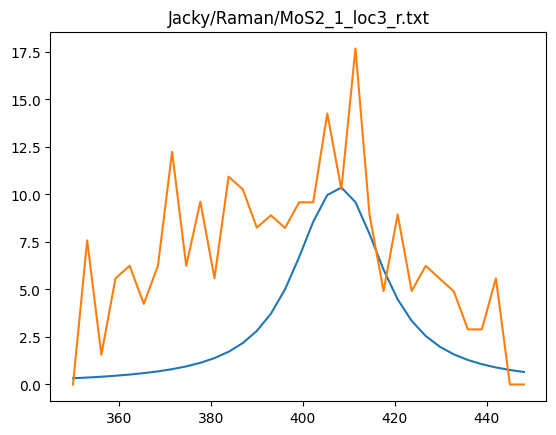

Jacky/Raman/MoS2_4_loc3_r.txt
Jacky/Raman/MoS2_3_loc4_r.txt
[[ 408.419    10.     1084.6501]
 [ 383.886    10.     1084.6501]]
Loss for curve 1 in Jacky/Raman/MoS2_3_loc4_r.txt : 1.7932276440222297
Loss for curve 2 in Jacky/Raman/MoS2_3_loc4_r.txt : 1238.7622121582654
[[ 407.52946431    3.02198986 1085.16860009]
 [ 382.85989539    2.84058558 1084.43333402]]


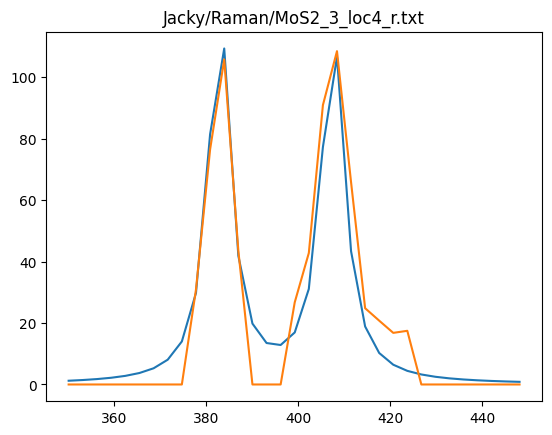

Jacky/Raman/FeMoS2_1_loc1_r.txt
Jacky/Raman/FeMoS2_1_loc3_r.txt
Jacky/Raman/MoS2_4_loc1_r.txt
[[405.357   10.     588.1413]
 [383.886   10.     588.1413]]
Loss for curve 1 in Jacky/Raman/MoS2_4_loc1_r.txt : 0.7613239364343923
Loss for curve 2 in Jacky/Raman/MoS2_4_loc1_r.txt : 486.45235462784103
[[406.35575694   2.88444912 588.18695806]
 [384.11998609   3.93339807 587.87769729]]


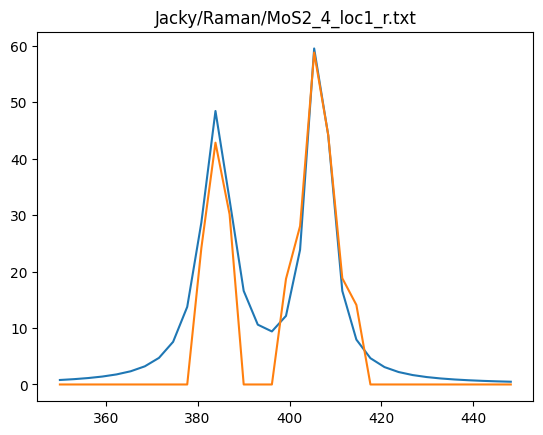

Jacky/Raman/MoS2_1_loc2_r.txt
[[408.419   10.     571.3356]
 [386.955   10.     571.3356]]
Loss for curve 1 in Jacky/Raman/MoS2_1_loc2_r.txt : 0.6025883190699655
Loss for curve 2 in Jacky/Raman/MoS2_1_loc2_r.txt : 1194.1493589079848
[[408.38763812   3.61631895 572.05628957]
 [387.3472073    4.03842005 571.82573524]]


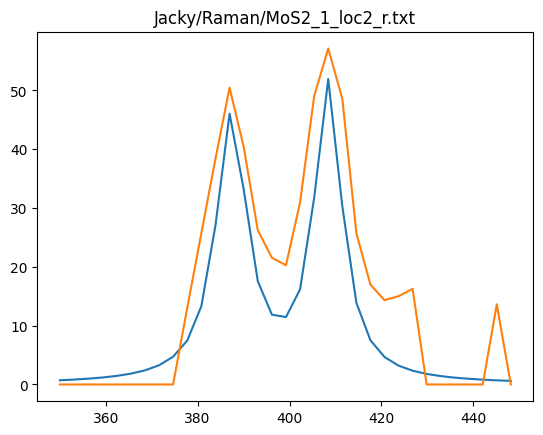

Jacky/Raman/MoS2_3_loc1_r.txt
[[408.419   10.     970.8233]
 [383.886   10.     970.8233]]
Loss for curve 1 in Jacky/Raman/MoS2_3_loc1_r.txt : 1.8665455544222733
Loss for curve 2 in Jacky/Raman/MoS2_3_loc1_r.txt : 958.0763554894518
[[408.31127635   3.31215451 971.3724226 ]
 [384.36098293   3.65162182 970.75715322]]


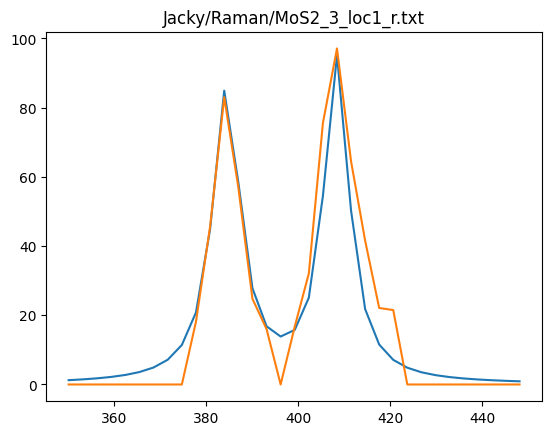

Jacky/Raman/FeMoS2_1_loc4_r.txt
Jacky/Raman/MoS2_4_loc4_r.txt
Jacky/Raman/MoS2_3_loc3_r.txt
[[ 411.482   10.    1448.135]
 [ 383.886   10.    1448.135]]
Loss for curve 1 in Jacky/Raman/MoS2_3_loc3_r.txt : 3.408712478365519
Loss for curve 2 in Jacky/Raman/MoS2_3_loc3_r.txt : 2303.8321052874635
[[ 410.13451488    2.82842899 1449.19173377]
 [ 384.02683599    3.34603747 1448.38706622]]


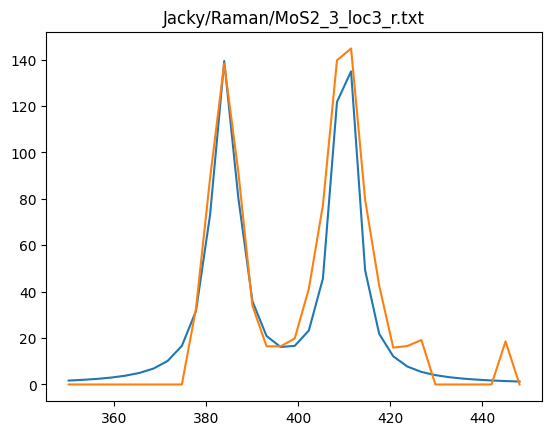

Jacky/Raman/FeMoS2_1_loc6_r.txt
Jacky/Raman/FeMoS2_1_loc2_r.txt
Jacky/Raman/MoS2_1_loc4_r.txt
[[408.419       10.         633.83356667]
 [390.025       10.         633.83356667]]
Loss for curve 1 in Jacky/Raman/MoS2_1_loc4_r.txt : 0.9010651633294458
Loss for curve 2 in Jacky/Raman/MoS2_1_loc4_r.txt : 988.5920337036741
[[409.76133825   3.10179435 634.39642495]
 [387.56398777   4.95379575 633.92907121]]


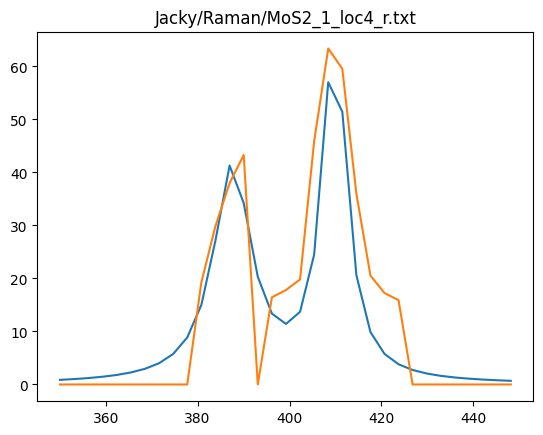

Jacky/Raman/MoS2_4_loc2_r.txt
[[ 408.419        10.         1024.39233333]
 [ 383.886        10.         1024.39233333]]
Loss for curve 1 in Jacky/Raman/MoS2_4_loc2_r.txt : 1.9059154343307174
Loss for curve 2 in Jacky/Raman/MoS2_4_loc2_r.txt : 821.987013040333
[[ 407.83316462    3.17654248 1024.83876615]
 [ 384.51264036    3.5053009  1024.47913961]]


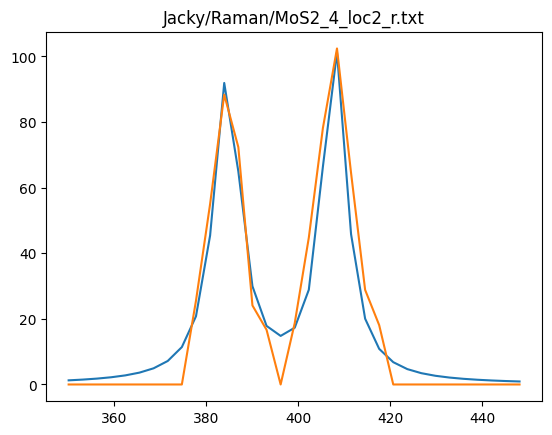

In [51]:
sample_df, _ = create_csv(sample_folder_list, "SampleRaman_.txt")